In [1]:
import torch
from torch import optim
import matplotlib.pyplot as plt
from torch.distributions import kl_divergence
from utils import varFKL, FKL, RKL, plot_distribs
from utils import GaussianParticle, GaussianMixture

## 1. Fitting simple Gaussians

We start by defining a simple gaussian target:

In [3]:
# Non trainable Gaussian particle, target of the model.
target = GaussianParticle(
    loc=torch.tensor([3,3], dtype=torch.float),
    scale_tril=0.3*torch.eye(2),
    trainable=False
)

### 1.1 RKL

In [10]:
# Trainable Gaussian particle with random initialization.
model = GaussianParticle(
    loc=torch.randn(2),
    scale_tril=torch.eye(2),
    trainable=True
)

# optimization procedure:
opt = optim.Adam(model.parameters(), lr=0.01)

for step in range(2000):
    loss = kl_divergence(p=target.mvn, q=model.mvn)

    opt.zero_grad()
    loss.backward()
    opt.step()

    # logging:
    if step%200==0:
        print(f'step:{step}, loss:{loss.detach().numpy()}')

step:0, loss:8.985939025878906
step:200, loss:2.469557762145996
step:400, loss:1.458482027053833
step:600, loss:0.6209438443183899
step:800, loss:0.0
step:1000, loss:-1.1920928955078125e-07
step:1200, loss:-1.1920928955078125e-07
step:1400, loss:-1.1920928955078125e-07
step:1600, loss:-1.1920928955078125e-07
step:1800, loss:-1.1920928955078125e-07


Visualizing the distributions after optimization:

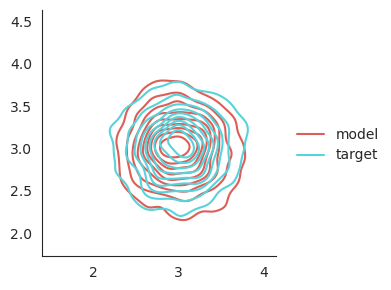

In [11]:
plot_distribs({'model':model, 'target':target})

### 1.2 FKL

The main difference is that we need to initialize our model, we choose a centered and diffuse Gaussian distribution.

In [13]:
# Initializing a Gaussian mixture model with a non-trainable diffuse gaussian distributions:
init= GaussianParticle(
    loc=torch.zeros(2),
    scale_tril=2*torch.eye(2),
    trainable=False
)
model = GaussianMixture(init)

# Trainable Gaussian particle with random initialization.
particle = GaussianParticle(
    loc=torch.randn(2),
    scale_tril=torch.eye(2),
    trainable=True
)

# Optimization procedure:
opt = optim.Adam(particle.parameters(), lr=0.01)

for step in range(2000):
    loss = FKL(
        f=particle,
        q=model,
        p=target
    )
    
    opt.zero_grad()
    loss.backward()
    opt.step()

    # logging:
    if step%200==0:
        print(f'step:{step}, loss:{loss.detach().numpy()}')

# Adding the new particle to the model:
model.add_particle(particle)

step:0, loss:5.634288787841797
step:200, loss:1.6319167613983154
step:400, loss:0.09860114753246307
step:600, loss:0.032480258494615555
step:800, loss:0.1350155770778656
step:1000, loss:0.058463361114263535
step:1200, loss:-0.03417259827256203
step:1400, loss:0.0065536051988601685
step:1600, loss:0.0037253927439451218
step:1800, loss:0.014394763857126236


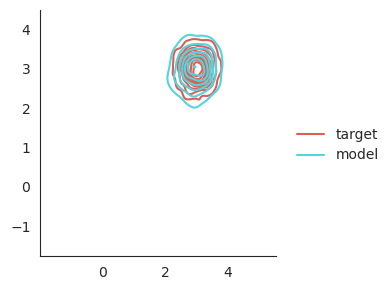

In [14]:
plot_distribs({'target':target, 'model':model})

## 2. Fitting a multimodal target

Defining the target:

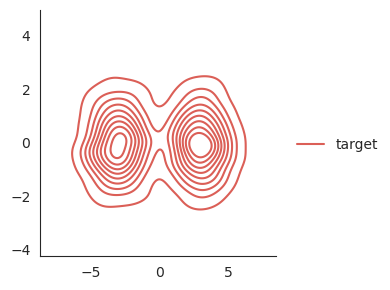

In [2]:
# Non trainable gaussian mixture:
particle1 = GaussianParticle(
    loc=torch.tensor([3,0], dtype=torch.float),
    scale_tril=torch.eye(2),
    trainable=False
)
particle2 = GaussianParticle(
    loc=torch.tensor([-3,0], dtype=torch.float),
    scale_tril=torch.eye(2),
    trainable=False
)
target = GaussianMixture(particle1)
target.add_particle(particle2)

plot_distribs({'target':target}, nsamples=2000)

### 2.1 RKL

In [3]:
# Trainable Gaussian particle with random initialization.
model = GaussianParticle(
    loc=torch.zeros(2),
    scale_tril=torch.eye(2),
    trainable=True
)

# optimization procedure:
opt = optim.Adam(model.parameters(), lr=0.001)

for step in range(5000):
    # We don't have acces to closed form KL, we use a MCMC estimation of the KL with reparametrization trick:
    loss = RKL(p=target, q=model)

    opt.zero_grad()
    loss.backward()
    opt.step()

    # logging:
    if step%500==0:
        print(f'step:{step}, loss:{loss.detach().numpy()}')

step:0, loss:2.739382266998291
step:500, loss:1.5320963859558105
step:1000, loss:nan
step:1500, loss:nan
step:2000, loss:nan
step:2500, loss:-6693.2041015625
step:3000, loss:-6745.64111328125
step:3500, loss:-7888.837890625
step:4000, loss:-8218.771484375
step:4500, loss:-8483.12109375


(-6.0, 6.0)

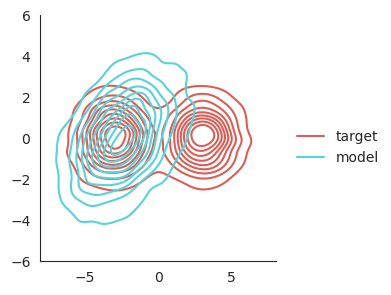

In [4]:
plot_distribs({'target':target, 'model':model}, nsamples=2000)
plt.xlim([-8, 8])
plt.ylim([-6, 6])

### 2.2 Direct FKL computation

In [10]:
# Trainable Gaussian particle with random initialization.
model = GaussianParticle(
    loc=torch.zeros(2),
    scale_tril=torch.eye(2),
    trainable=True
)

# optimization procedure:
opt = optim.Adam(model.parameters(), lr=0.001)

for step in range(3000):
    # We use a MCMC estimation of the FKL, as explained in the paper this has high variance,
    # but in simple cases it sometimes works.
    loss = varFKL(p=target, q=model)

    opt.zero_grad()
    loss.backward()
    opt.step()

    # logging:
    if step%500==0:
        print(f'step:{step}, loss:{loss.detach().numpy()}')

step:0, loss:1.9597041606903076
step:500, loss:1.9830377101898193
step:1000, loss:1.181197166442871
step:1500, loss:0.8463190793991089
step:2000, loss:0.6759629249572754
step:2500, loss:0.6021292805671692


(-6.0, 6.0)

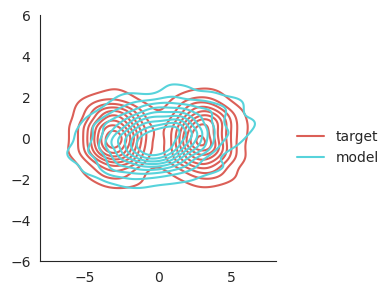

In [11]:
plot_distribs({'target':target, 'model':model}, nsamples=2000)
plt.xlim([-8, 8])
plt.ylim([-6, 6])

### 2.2 FKL from diffuse initialization

In [5]:
# Initializing a Gaussian mixture model with a non-trainable diffuse gaussian distributions:
init= GaussianParticle(
    loc=torch.zeros(2),
    scale_tril=2*torch.eye(2),
    trainable=False
)
model = GaussianMixture(init)

# Trainable Gaussian particle with random initialization.
particle = GaussianParticle(
    loc=torch.randn(2),
    scale_tril=torch.eye(2),
    trainable=True
)

# Optimization procedure:
opt = optim.Adam(particle.parameters(), lr=0.005)

for step in range(3000):
    loss = FKL(
        q=model,
        p=target,
        f=particle
    )
    
    opt.zero_grad()
    loss.backward()
    opt.step()

    # logging:
    if step%300==0:
        print(f'step:{step}, loss:{loss.detach().numpy()}')

# Adding the new particle to the model:
model.add_particle(particle)

step:0, loss:1.2200167179107666
step:300, loss:0.887636661529541
step:600, loss:0.7450747489929199
step:900, loss:0.7009865641593933
step:1200, loss:0.8762811422348022
step:1500, loss:0.644127368927002
step:1800, loss:0.6755275130271912
step:2100, loss:0.7803300619125366
step:2400, loss:0.6474167108535767
step:2700, loss:0.6254973411560059


(-6.0, 6.0)

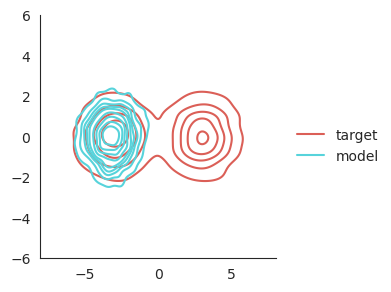

In [6]:
plot_distribs({'target':target, 'model':particle}, nsamples=2000)
plt.xlim([-8, 8])
plt.ylim([-6, 6])

## 3. Fitting a boosting model on a complex multi-modal distribution.

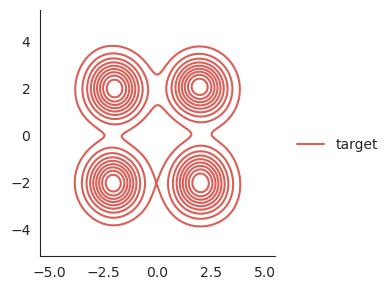

In [2]:
# Non trainable gaussian mixture:
particle1 = GaussianParticle(
    loc=torch.tensor([2,2], dtype=torch.float),
    scale_tril=0.5*torch.eye(2),
    trainable=False
)
particle2 = GaussianParticle(
    loc=torch.tensor([-2,2], dtype=torch.float),
    scale_tril=0.5*torch.eye(2),
    trainable=False
)
particle3 = GaussianParticle(
    loc=torch.tensor([2,-2], dtype=torch.float),
    scale_tril=0.5*torch.eye(2),
    trainable=False
)
particle4 = GaussianParticle(
    loc=torch.tensor([-2,-2], dtype=torch.float),
    scale_tril=0.5*torch.eye(2),
    trainable=False
)
multimodal_target = GaussianMixture(particle1)
multimodal_target.add_particle(particle2)
multimodal_target.add_particle(particle3)
multimodal_target.add_particle(particle4)

multimodal_target.weights = torch.ones(4)/4

plot_distribs({'target':multimodal_target}, nsamples=2000)

In [3]:
# Diffuse initialization:
init = GaussianParticle(
    loc=torch.tensor([0.,0.]),
    scale_tril=2*torch.eye(2),
    trainable=False
)

# FKL BOOSTING:
model = GaussianMixture(init)

K = 3
for i in range(K):
    print(f'### step={i+1}, fitting a new particle ###')
    new_particle = GaussianParticle(
        loc=torch.randn(2),
        scale_tril=torch.eye(2),
        trainable=True
    )

    opt = optim.Adam(new_particle.parameters(), lr=0.001)

    for step in range(3000):
        loss = FKL(
            q=model,
            p=multimodal_target,
            f=new_particle
        )
        
        opt.zero_grad()
        loss.backward()
        opt.step()

        # logging:
        if step%500==0:
            print(f'step:{step}, loss:{loss.detach().numpy()}')
    
    for param in new_particle.parameters():
        param.requires_grad = False

    model.add_particle(new_particle)

### step=1, fitting a new particle ###
step:0, loss:1.8956661224365234
step:500, loss:1.4476268291473389
step:1000, loss:1.4624648094177246
step:1500, loss:1.4177939891815186
step:2000, loss:1.4087200164794922
step:2500, loss:1.395285725593567
### step=2, fitting a new particle ###
step:0, loss:1.8647351264953613
step:500, loss:1.5899591445922852
step:1000, loss:1.4083809852600098
step:1500, loss:1.1358346939086914
step:2000, loss:1.2979251146316528
step:2500, loss:1.3484692573547363
### step=3, fitting a new particle ###
step:0, loss:1.7056491374969482
step:500, loss:1.3764433860778809
step:1000, loss:1.2986637353897095
step:1500, loss:1.231626272201538
step:2000, loss:nan
step:2500, loss:1.0377020835876465


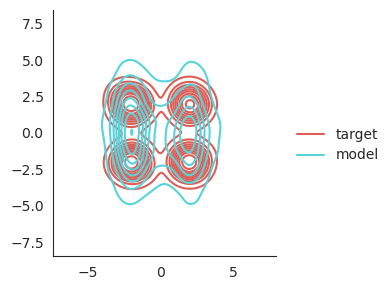

In [4]:
plot_distribs({'target':multimodal_target, 'model':model}, nsamples=2000)

In [5]:
print(f'mixture weights: {model.weights}')
for i in range(len(model.particles)):
    print(f'particle {i}, mean = {model.particles[i].loc.detach().numpy()}')

mixture weights: tensor([0.3317, 0.1019, 0.1894, 0.3770])
particle 0, mean = [0. 0.]
particle 1, mean = [ 0.76238495 -0.21792221]
particle 2, mean = [2.058939   0.01926257]
particle 3, mean = [-2.0445333e+00 -1.4215467e-03]


We initialize a model with a centered diffuse gaussian:

In [6]:
# False RKL initialization:
init = GaussianParticle(
    loc=torch.tensor([-2,-2.]), # If RKL is initialized where there is no mass, it crashes.
    scale_tril=0.5*torch.eye(2),
    trainable=False
)

# FKL BOOSTING:
model = GaussianMixture(init)

K = 3
for i in range(K):
    print(f'### step={i+1}, fitting a new particle ###')
    new_particle = GaussianParticle(
        loc=torch.randn(2),
        scale_tril=torch.eye(2),
        trainable=True
    )

    opt = optim.Adam(new_particle.parameters(), lr=0.001)

    for step in range(3000):
        loss = FKL(
            q=model,
            p=multimodal_target,
            f=new_particle
        )
        
        opt.zero_grad()
        loss.backward()
        opt.step()

        # logging:
        if step%500==0:
            print(f'step:{step}, loss:{loss.detach().numpy()}')
    
    for param in new_particle.parameters():
        param.requires_grad = False

    model.add_particle(new_particle)

### step=1, fitting a new particle ###
step:0, loss:-0.8301727771759033
step:500, loss:-1.0768909454345703
step:1000, loss:-1.2097034454345703
step:1500, loss:-1.302556037902832
step:2000, loss:-1.3746685981750488
step:2500, loss:-1.3859508037567139
### step=2, fitting a new particle ###
step:0, loss:-0.8649847507476807
step:500, loss:-1.1346579790115356
step:1000, loss:-1.2717747688293457
step:1500, loss:-1.2465558052062988
step:2000, loss:-1.364081621170044
step:2500, loss:-1.372618556022644
### step=3, fitting a new particle ###
step:0, loss:-0.9430207014083862
step:500, loss:-1.1513402462005615
step:1000, loss:-1.292537808418274
step:1500, loss:-1.3616838455200195
step:2000, loss:-1.373347282409668
step:2500, loss:-1.383265733718872


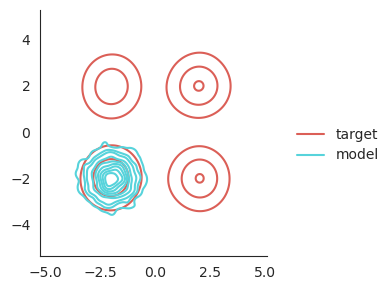

In [7]:
plot_distribs({'target':multimodal_target, 'model':model}, nsamples=2000)

In [8]:
print(f'mixture weights: {model.weights}')
for i in range(len(model.particles)):
    print(f'particle {i}, mean = {model.particles[i].loc.detach().numpy()}')

mixture weights: tensor([0.4251, 0.1280, 0.1687, 0.2782])
particle 0, mean = [-2. -2.]
particle 1, mean = [-1.9503438 -1.9794375]
particle 2, mean = [-1.9399827 -1.9936993]
particle 3, mean = [-1.9877733 -2.0039637]
